Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from glob import glob

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration\Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:

train_ds =  tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),label_mode='categorical',
                                                              seed=123,subset="training",validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),label_mode='categorical',
                                                              seed=123,subset="validation",validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

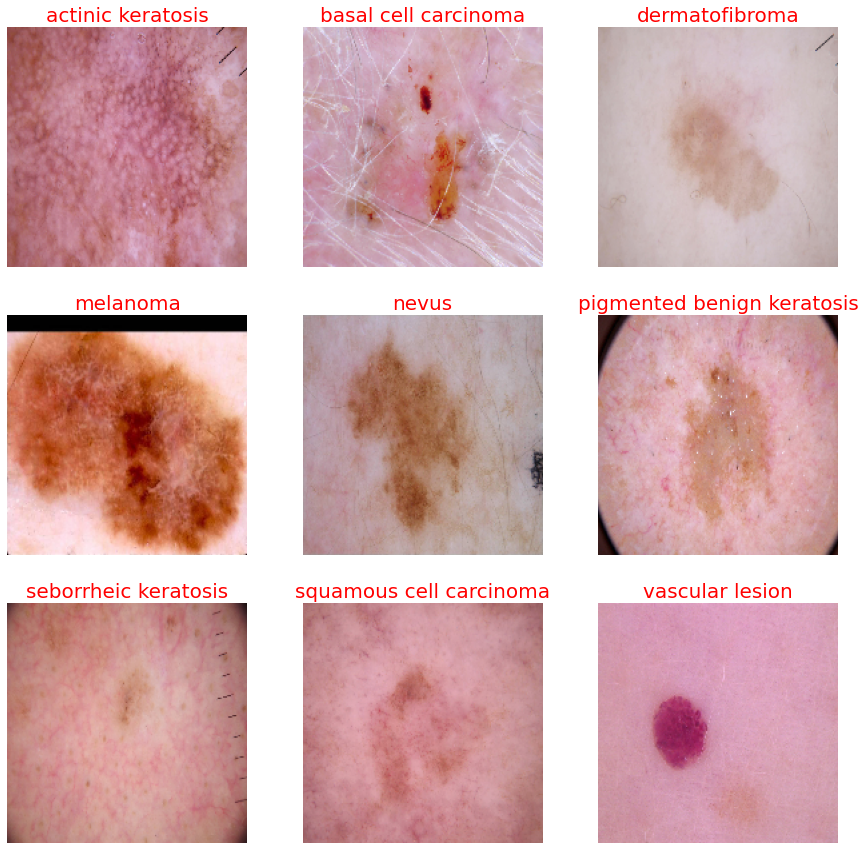

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns 
import random
from tensorflow.keras.preprocessing.image import load_img
#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    num=random.randint(0,50)
    path_list = files_path_dict[c][num:num+1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_height,img_width)))
    plt.title(c,fontdict={'color':'r','fontsize':20})
    plt.axis("off")

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [11]:
#Fixing input shape the last 3 as the image has 3 layer Red , Green and Blue
input_shape=(img_height,img_width,3)

#Building the model
model = Sequential()

#First Convulation Layer

# First step is to standardize the value which can be done by dividing each pixel value by 255
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
#we can now add the filter layer , kernel size 3X3 with 32 kernels 
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
#next we need a pooling layer to reduce the features here we use max pooler with a filter size of 2x2
model.add(layers.MaxPool2D(pool_size=(2,2)))
# We will use similar logic to add more layers in the model 

#Second Convulation Layer  (we always increase the number of filter in the next layer so we use 64 filter as compared to 32 in the previous layer)
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Fourth Convolution Layer
model.add(layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#now that our hidden layers are done we need to flatten the output so that it can be used by the output layer
model.add(layers.Flatten())

#now we add a dense layer to connect all the flattend values to the output layer
model.add(layers.Dense(512,activation='relu'))
# reducing features connected to the output 
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(128,activation='relu'))

#We use softmax as our output layer because this is a multi class problem
model.add(layers.Dense(len(class_names),activation='softmax'))


### Compile the model


In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 74s 1s/step - loss: 2.0521 - accuracy: 0.1842 - val_loss: 2.0642 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 70s 1s/step - loss: 1.9798 - accuracy: 0.2517 - val_loss: 1.8120 - val_accuracy: 0.3803
Epoch 3/20
56/56 [==============================] - 73s 1s/step - loss: 1.6957 - accuracy: 0.3761 - val_loss: 1.5168 - val_accuracy: 0.4609
Epoch 4/20
56/56 [==============================] - 75s 1s/step - loss: 1.5247 - accuracy: 0.4693 - val_loss: 1.4851 - val_accuracy: 0.5056
Epoch 5/20
56/56 [==============================] - 75s 1s/step - loss: 1.4548 - accuracy: 0.4900 - val_loss: 1.5282 - val_accuracy: 0.5011
Epoch 6/20
56/56 [==============================] - 77s 1s/step - loss: 1.4615 - accuracy: 0.4833 - val_loss: 1.4494 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 74s 1s/step - loss: 1.3804 - accuracy: 0.5123 - val_loss: 1.3870 - val_accuracy: 0.5280
Epoch 8/20
56/56 [==

### Visualizing training results

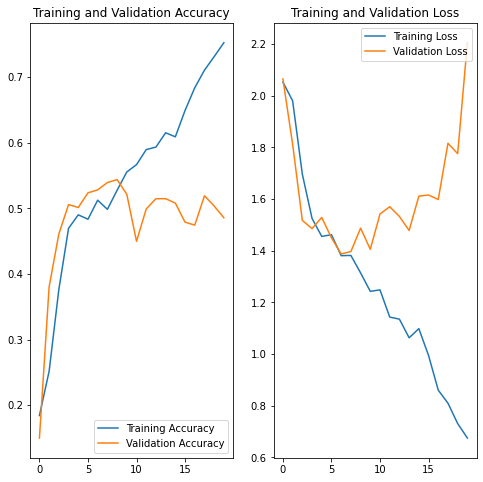

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### The accuracy of the train set decreses over epochs but the validation set bottoms out .. this tells us that there is major over fitting issues . we cab try to fix this by rebuilding the model with a slightly different architecture 

In [16]:

#Data augumentation strategy. 

rescale = tf.keras.Sequential([
  #To rescale an input in the [0, 255] range to be in the [0, 1] range  
  layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  #Randomly flip each image horizontally and vertically.
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    
  #Randomly rotate each image.
  layers.experimental.preprocessing.RandomRotation(0.2),
    
  #Randomly zoom each image during training.
  layers.experimental.preprocessing.RandomZoom(0.2),
    
  #Randomly translate each image during training.
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)    
])

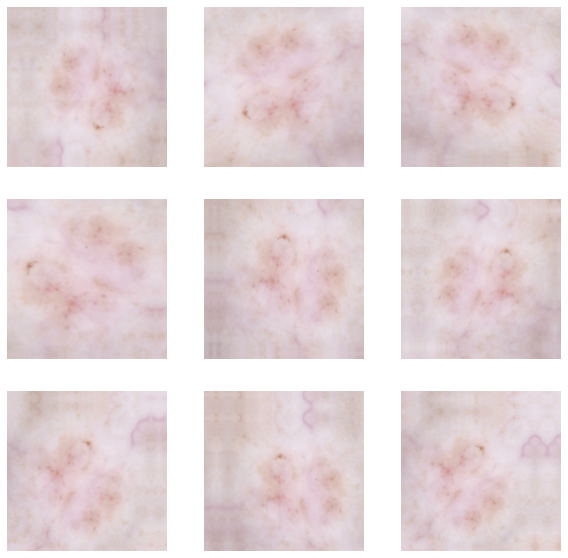

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):   
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off") 


### Creating the model, compile and train the model with drop outs


In [18]:
model2= Sequential()
# Data augmentation
model2.add(data_augmentation)
#Data scaling
model2.add(rescale)
#First Convulation Layer
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))
model2.add(layers.Dropout(0.25)) # droppout layer where connections below 25% will be turned off
#Second Convulation Layer
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))
model2.add(layers.Dropout(0.25))
#Third Convulation Layer
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

# since we will be flatting in the next step we can do a drop out after flatning 
model2.add(layers.Flatten())
model2.add(layers.Dense(512,activation='relu'))# layer to connect all the fattened values
model2.add(layers.Dense(128,activation='relu'))
model2.add(layers.Dropout(0.50))# high drop out layer to prevent over fitting 
#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model2.add(layers.Dense(len(class_names),activation='softmax'))




### Compiling the model

In [19]:
model2.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

### Training the model

In [20]:
epochs =20
history = model2.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/20
56/56 [==============================] - 80s 1s/step - loss: 2.3990 - accuracy: 0.1797 - val_loss: 2.0651 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 82s 1s/step - loss: 2.0624 - accuracy: 0.1959 - val_loss: 2.0356 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 80s 1s/step - loss: 2.0305 - accuracy: 0.2037 - val_loss: 2.0311 - val_accuracy: 0.2662
Epoch 4/20
56/56 [==============================] - 73s 1s/step - loss: 1.9641 - accuracy: 0.2522 - val_loss: 1.8504 - val_accuracy: 0.3512
Epoch 5/20
56/56 [==============================] - 80s 1s/step - loss: 1.8674 - accuracy: 0.3064 - val_loss: 1.6984 - val_accuracy: 0.3893
Epoch 6/20
56/56 [==============================] - 80s 1s/step - loss: 1.8233 - accuracy: 0.3265 - val_loss: 1.8038 - val_accuracy: 0.3177
Epoch 7/20
56/56 [==============================] - 83s 1s/step - loss: 1.7460 - accuracy: 0.3638 - val_loss: 1.6148 - val_accuracy: 0.4407
Epoch 8/20
56/56 [==

### Visualizing the results

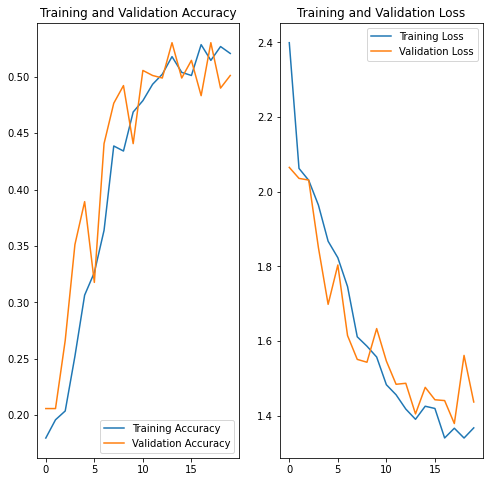

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### We can see that the model is working well and not over fitting but has an over all low accuracy 
### We can improve the data by balancing the data by augmenting the data and balancing the classes

,Class,No. of Image
5,pigmented benign keratosis,462
3,melanoma,438
1,basal cell carcinoma,376
4,nevus,357
7,squamous cell carcinoma,181
8,vascular lesion,139
0,actinic keratosis,114
2,dermatofibroma,95
6,seborrheic keratosis,77


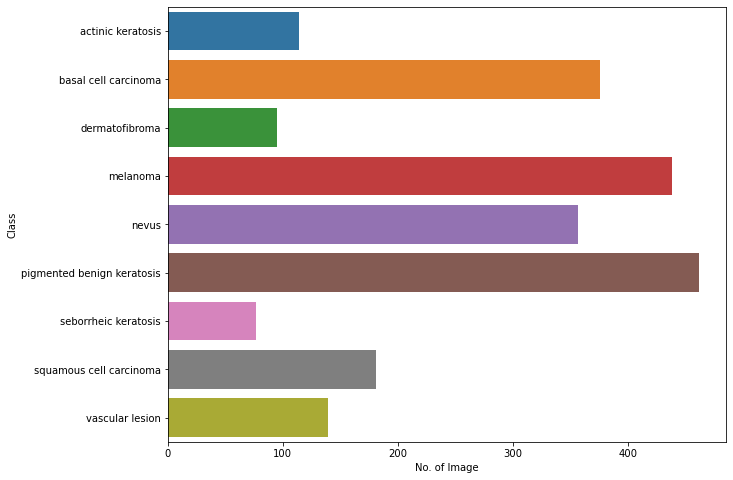

In [22]:
#class imbalance detection
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
#Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")
display(df.sort_values(by='No. of Image',ascending= False))

## We have a lot of samples for pigmented benign keratosis 
## We have very low samples of seborrheic keratosis	
### the best way to handle this is to increase the samples in each of the classes with data augmentation 

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [23]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [24]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=15, max_right_rotation=15)
    p.sample(500) # We made each class have 700 images as we want to surpress the imbalance

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CE47A1F820>: 100%|█| 500/500 [00:04<00:00, 113.44 Samples


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CE21FF5CD0>: 100%|█| 500/500 [00:04<00:00, 113.88 Samples


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CE29026910>: 100%|█| 500/500 [00:04<00:00, 108.71 Samples


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x1CE21EC10A0>: 100%|█| 500/500 [00:26<00:00, 19.18 Sample


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x1CE162F3D30>: 100%|█| 500/500 [00:32<00:00, 15.45 Samples/


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1CE16BC3D00>: 100%|█| 500/500 [00:04<00:


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1CE087E00D0>: 100%|█| 500/500 [00:09<00:00, 50.02 Samples


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1CE1A70DE80>: 100%|█| 500/500 [00:04<00:


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CE164E64C0>: 100%|█| 500/500 [00:04<00:00, 116.53 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [25]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [26]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_2d57c469-26bb-4ba2-a5ff-a840c2529808.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7ecdd74f-ee7b-4213-81cb-177db88696d9.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_08d06fd5-ab6c-4743-a467-46a4aa1e4592.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_172cd65e-bb13-48df-86a9-ea2216824ae1.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_776fae77-a1eb-4760-b041-7c9b2ee7f82b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train

In [27]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [28]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [29]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [30]:
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

####  Training the model on the data created using Augmentors data set

In [31]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [32]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [33]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Model Creation

In [34]:
Final_model = Sequential()

Final_model.add(rescale)   #Rescaling Layer

#First Convulation layer
Final_model.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
Final_model.add(layers.MaxPool2D(pool_size=(2,2)))
Final_model.add(layers.Dropout(0.25))

#Second Convulation Layer
Final_model.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
Final_model.add(layers.MaxPool2D(pool_size=(2,2)))
Final_model.add(layers.Dropout(0.25))

#Third Convulation Layer
Final_model.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
Final_model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
Final_model.add(layers.Flatten())

#Dense Layer
Final_model.add(layers.Dense(512,activation='relu'))

#Dropout layer
Final_model.add(layers.Dropout(0.25))

#Batch normalization: is a method used to make artificial neural networks faster and more stable through normalization 
#of the layers' inputs by re-centering and re-scaling.
Final_model.add(layers.BatchNormalization())

#Dense Layer
Final_model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
Final_model.add(layers.Dropout(0.50))

#Batch normalization
Final_model.add(layers.BatchNormalization())

#Dense layer with Softmax activation function.
Final_model.add(layers.Dense(len(class_names),activation='softmax'))

#### Compile model

In [35]:
Final_model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [36]:
from os.path import exists
import pickle
from numpy.random import seed
seed(123)
tf.random.set_seed(123)
epochs = 30

file_exists = exists('Final_model.h5')
if file_exists:
    Final_model=keras.models.load_model('Final_model.h5')
    
    history = pickle.load(open('trainHistoryDict', "rb"))
else:
    epochs = 30
    
    history = Final_model.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1,)
    import pickle
    with open('trainHistoryDict', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
    Final_model.save("Final_model.h5")
    history=history.history

Epoch 1/30
169/169 [==============================] - 186s 1s/step - loss: 2.4269 - accuracy: 0.1858 - val_loss: 3.6408 - val_accuracy: 0.1418
Epoch 2/30
169/169 [==============================] - 194s 1s/step - loss: 1.8706 - accuracy: 0.3142 - val_loss: 3.4969 - val_accuracy: 0.2027
Epoch 3/30
169/169 [==============================] - 197s 1s/step - loss: 1.6985 - accuracy: 0.3622 - val_loss: 1.9340 - val_accuracy: 0.2851
Epoch 4/30
169/169 [==============================] - 196s 1s/step - loss: 1.5815 - accuracy: 0.4021 - val_loss: 1.6809 - val_accuracy: 0.3430
Epoch 5/30
169/169 [==============================] - 196s 1s/step - loss: 1.4868 - accuracy: 0.4349 - val_loss: 1.5642 - val_accuracy: 0.3920
Epoch 6/30
169/169 [==============================] - 196s 1s/step - loss: 1.4389 - accuracy: 0.4514 - val_loss: 1.5623 - val_accuracy: 0.3526
Epoch 7/30
169/169 [==============================] - 196s 1s/step - loss: 1.3719 - accuracy: 0.4768 - val_loss: 1.4673 - val_accuracy: 0.4068

####  Visualize the model results

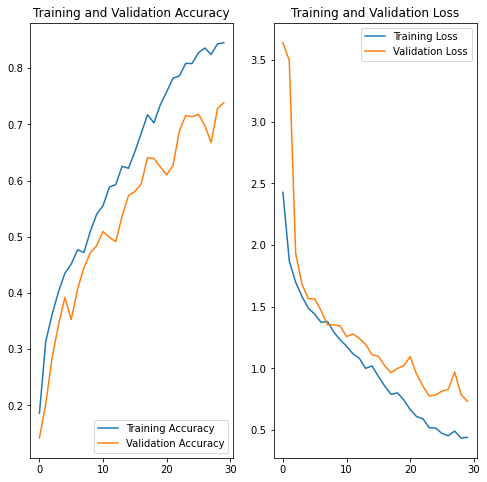

In [37]:
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings
Model is almost stable , the Train and validation is 10% apart which is a good output for the model
Things that got the model to perform well:
* Augmentation : with Augmentation we produced a good number of samples for the model to learn well
* Dropouts : This is one of the most basic form of regularization that turns off nurons that might be causing over fitting and do not have a high enough weight to them 
* BatchNormalization : Layer that normalizes its inputs.Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1, making the model run faster.
* Smaller Kernel size to get more details from the features 

All the above steps helped us achive good results even with limited resources in term of training data and computational ability.
